# Displaying Molecular Formulas in Molecular Grids, Tables, and Graphs for Elemental Analysis

Here's how to display formatted molecular formulas in tables and graphs. In addition to formatted molecular formulas, these techniques should work for any Markdown or LaTeX.

In the [last blog post, we generated molecular formulas]({% post_url 2023-10-20-Molecular-Formula-Generation %}) from SMILES strings or RDKit molecules. Once we have those molecular formulas, formatted as Markdown or LaTeX, we might want to display them in tables or graphs.

One of the uses of a molecular formula is for [elemental analysis](https://en.wikipedia.org/wiki/Elemental_analysis#CHNX_analysis) because it determines the mass percentage of each element in a compound. So all we need to know for elemental analysis is the count of each element in the molecule, not the arrangement of atoms.

*[Open this notebook in Google Colab so you can run it without installing anything on your computer](https://colab.research.google.com/drive/1yKMPFeBPQGeHYqQooUlF36eL4zDXgc-l?usp=sharing)*

In [2]:
%%capture
%!pip install rdkit
%!pip install black[jupyter]
%!pip install polars
%!pip install pyarrow

In [3]:
from collections import defaultdict
from IPython.display import display, Markdown

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import MolsMatrixToGridImage
from rdkit.Chem.Draw import MolsToGridImage
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Molecular formula generation code from previous blog post

Refer to the [previous post]({% post_url 2023-10-20-Molecular-Formula-Generation %}) for more information on these functions.

In [4]:
def composition(
    molecule: Chem.Mol,
    isotopes: bool = False,
) -> defaultdict:
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and isotopes if requested.
    For example, ethanol (SMILES [13C](H)(H)(H)CO, formula C2H6O) returns:
      if isotopes = False (default): {'C': 2, 'O': 1, 'H': 6}.
      if isotopes = True: {'C': {13: 1, 0: 1}, 'O': {0: 1}, 'H': {0: 6}}.

    :param molecule: The RDKit molecule to analyze
    :param isotopes: Whether to include the isotope of each atom
    :returns: if isotopes = False (default): a dictionary of element:count entries;
              if isotopes = True: a nested dictionary of element:isotope:count entries.
    """
    # Check that there is a valid molecule
    if not molecule:
        return

    # Add hydrogen atoms--RDKit excludes them by default
    molecule = Chem.AddHs(molecule)
    comp = defaultdict(lambda: 0)

    # Get atom counts
    for atom in molecule.GetAtoms():
        element_symbol = atom.GetSymbol()
        # If isotopes not requested, simply count the number of atoms of each element
        if not isotopes:
            comp[element_symbol] += 1
        # If isotopes requested, count the number of each isotope of each element
        else:
            isotope = atom.GetIsotope()
            try:
                comp[element_symbol][isotope] += 1
            except:
                comp[element_symbol] = defaultdict(lambda: 0)
                comp[element_symbol][isotope] += 1
    return comp

In [5]:
def mol_to_formatted_formula(
    mol: Chem.Mol,
    isotopes: bool = False,
) -> dict[str, str]:
    """Convert an RDKit molecule to a formatted formula, in Markdown and LaTeX

    :param mol: RDKit molecule
    :param isotopes: Whether to consider isotopes
    :returns: a dictionary of format:string pairs, e.g. {"markdown":"markdown_string", "latex":"latex_string"}
    """
    if mol is None:
        return "Invalid molecule"
    comp = composition(mol, isotopes)

    formula = {"markdown": "", "latex": ""}

    if isotopes:
        isotopes_dict = defaultdict(lambda: defaultdict(str))
        subscripts = defaultdict(lambda: defaultdict(int))
        superscripts = defaultdict(list)

        for element, counts in comp.items():
            for isotope, count in counts.items():
                if count > 1:
                    subscripts[element][isotope] = count
                if isotope != 0:
                    superscripts[element].append(isotope)

                isotopes_dict[element][isotope] = 1
            # Sort the element's isotopes from lowest to highest
            superscripts[element].sort()

        last_item_is_subscript = False
        sorted_element_keys = sorted(isotopes_dict.keys())
        for element in sorted_element_keys:
            isotope_count_pairs = isotopes_dict[element]
            # Sort the element's isotopes from lowest to highest
            sorted_isotope_keys = sorted(isotope_count_pairs.keys())
            for isotope in sorted_isotope_keys:
                if element in superscripts:
                    if isotope in superscripts[element]:
                        formula["markdown"] += f"<sup>{isotope}</sup>"

                        # If superscript immediately follows subscript,
                        # add a small amount of horizontal space using an empty group {}
                        # to prevent them from vertically overlapping
                        if last_item_is_subscript:
                            formula["latex"] += "{}"
                        formula["latex"] += "^{ %d}" % isotope
                        last_item_is_subscript = False
                formula["markdown"] += element
                formula["latex"] += element
                last_item_is_subscript = False
                if element in subscripts:
                    if isotope in subscripts[element]:
                        isotope_count = subscripts[element][isotope]
                        formula["markdown"] += f"<sub>{isotope_count}</sub>"
                        formula["latex"] += "_{ %d}" % isotope_count
                    last_item_is_subscript = True
        # Add beginning and ending dollar signs to LaTeX formula
        formula["latex"] = "$" + formula["latex"] + "$"
    else:
        # Handling the case when isotopes is False
        sorted_element_keys = sorted(comp.keys())

        for element in sorted_element_keys:
            count = comp[element]
            formula["markdown"] += element
            formula["latex"] += element
            if count > 1:
                formula["markdown"] += f"<sub>{count}</sub>"
                formula["latex"] += "_{ %d}" % count
        formula["latex"] = "$" + formula["latex"] + "$"

    return formula

In [6]:
def markdown_formula(latex: str) -> str:
    """Make a LaTeX molecular formula non-italicized by removing math formatting
    :param latex: the molecular formula
    :returns: the non-italicized molecular formula
    """
    latex_markdown = r"$\mathrm{ %s}$" % (latex.strip("$"))
    return latex_markdown

In [7]:
def element_set(molecule: Chem.Mol) -> set[str]:
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: An RDKit molecule
    :returns: A set of strings of element abbreviations
    """
    # Check that there is a valid molecule
    if molecule:
        # Add hydrogen atoms--RDKit excludes them by default
        molecule_with_Hs = Chem.AddHs(molecule)
        atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
        return atom_symbols

## Creating a table with molecular formulas

To display molecular formulas in tables, we can use [Markdown](https://www.markdownguide.org/). The utility function `dict_list_to_markdown_table` formats a list of dictionaries as a Markdown table. This is convenient because a Polars dataframe can be made into a list of dictionaries using [Dataframe.rows(named=True)](https://pola-rs.github.io/polars/py-polars/html/reference/dataframe/api/polars.DataFrame.rows.html).

In [8]:
def dict_list_to_markdown_table(data: list, number_rows: bool = False) -> str:
    """
    Convert a list of dictionaries into a Markdown table.

    :param data: A list of dictionaries, where each dictionary corresponds to a row in the table.
    :param include_row_numbers: Whether to include a row number column.
    :returns: The Markdown-formatted table as a string.
    """
    if not data:
        return ""

    # Extract column headers from the keys of the first dictionary
    headers = data[0].keys()

    # If include_row_numbers is True, add the "Row #" column
    if number_rows:
        headers = ["#"] + list(headers)

    # Create the table headers
    table = "| " + " | ".join(headers) + " |\n"

    # Create the title divider line
    table += "|"
    for _ in headers:
        table += " --- |"
    table += "\n"

    # Create the table body
    for i, row in enumerate(data):
        if number_rows:
            row_data = [i + 1] + [row.get(header, "") for header in headers[1:]]
        else:
            row_data = [row.get(header, "") for header in headers]

        table += "| " + " | ".join(map(str, row_data)) + " |\n"

    return table

## Displaying molecular formulas in molecular grids

The set of molecules we'll consider have:
- a carbon chain three, two, or one atoms long, and
- two oxygen atoms, and 
- hydrogen atoms

The first series is dialdehydes, and the second is diols. For the purpose of this exercise, consider that it may be too difficult to do elemental analysis on gases, so we'll only analyze condensed phases. Thus carbon dioxide will be excluded.

We can take advantage of the new [feature that I contributed to the RDKit 2023.9.1 release, MolsMatrixToGridImage](https://greglandrum.github.io/rdkit-blog/posts/2023-10-25-molsmatrixtogridimage.html), to put each series in its own data structure and then plot each series in its own row without worrying about how many compounds are in each series. Taking advantage of the nested input parameters of [MolsMatrixToGridImage](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html#rdkit.Chem.Draw.MolsMatrixToGridImage) also means we don't have to add an empty placeholder SMILES string `""` for the excluded compound carbon dioxide, which would cause empty cells in tables or graphs below.

If you do not yet have RDKit 2023.9.1 or greater, the `except` block below will use [`MolsToGridImage`](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html#rdkit.Chem.Draw.MolsToGridImage) as a fallback. Note that a different list of SMILES has to be created to add the empty placeholder SMILES string `""`.

Either RDKit drawing function will correctly display Markdown in legends under the molecules, so we use `mol_to_formatted_formula(mol)["markdown"]`. LaTeX does not seem to be supported by those drawing functions. Because we'll calculate the weight percent of each element, including hydrogen, let's display the hydrogen atoms.

MolsMatrixToGridImage available in RDKit 2023.09.1 and used to produce this image.


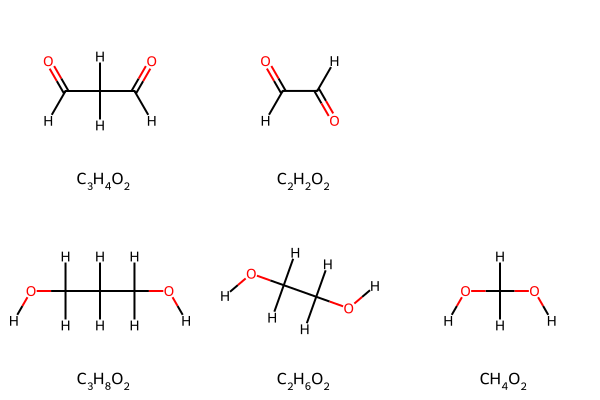

In [9]:
smlsDict = {"Dialdehydes": ["O=CCC=O", "O=CC=O"], "Diols": ["OCCCO", "OCCO", "OCO"]}
series_names = list(smlsDict.keys())
smlsMatrix = [value for key, value in smlsDict.items()]
molsMatrix = [
    [Chem.AddHs(Chem.MolFromSmiles(sml)) for sml in series] for series in smlsMatrix
]
legendsMatrix = [
    [mol_to_formatted_formula(mol)["markdown"] for mol in series]
    for series in molsMatrix
]

# Use MolsMatrixToGridImage if available; if not, fall back to MolsToGridImage, which requires some data structure changes
try:
    dwg = MolsMatrixToGridImage(molsMatrix, legendsMatrix=legendsMatrix)
except AttributeError:
    print(
        f"MolsMatrixToGridImage not available in RDKit {rdkit.__version__}; falling back to MolsToGridImage."
    )
    smls_one_dim = ["O=CCC=O", "O=CC=O", "", "OCCCO", "OCCO", "OCO"]
    mols_one_dim = [Chem.MolFromSmiles(sml) for sml in smls_one_dim]
    legends_one_dim = [
        mol_to_formatted_formula(mol)["markdown"] for mol in mols_one_dim
    ]
    dwg = MolsToGridImage(mols_one_dim, legends=legends_one_dim)
else:
    print(
        f"MolsMatrixToGridImage available in RDKit {rdkit.__version__} and used to produce this image."
    )

# Display the molecular grid image produced by the drawing function that was used
dwg

## Elemental analysis code

We define an `elemental_analysis_mol` class to hold the RDKit molecule, formulas, total mass, and the weight percent of each element in the molecule.

In [10]:
class elemental_analysis_mol:
    """Hold a molecule and the expected weight percent of each element therein"""

    def __init__(self, mol):
        self.mol = mol

        # Create dictionary of element:absolute mass
        element_abs_dict = defaultdict()
        for atom in mol.GetAtoms():
            try:
                element_abs_dict[atom.GetSymbol()] += atom.GetMass()
            except:
                element_abs_dict[atom.GetSymbol()] = atom.GetMass()

        formulas = mol_to_formatted_formula(self.mol)
        self.formula_markdown = formulas.get("markdown")
        self.formula_latex = formulas.get("latex")

        # Calculate total molecular mass as the sum of the mass of each atom
        self.total_mass = sum(element_abs_dict.values())

        # Create dictionary of element:relative (to the molecule) mass
        self.element_rel_dict = defaultdict()
        for element, mass in element_abs_dict.items():
            self.element_rel_dict[element] = mass / self.total_mass

    def update(self, mol):
        """Define an update method so the elemental_analysis_mol can remain as the same object if updated"""
        self.__init__(mol)

    def get_mass_frac(self, element):
        return self.element_rel_dict.get(element, 0)

We'll build a Polars dataframe with the SMILES, `elemental_analysis_mol`, and formulas.

In [11]:
smls = [sml for series in smlsMatrix for sml in series]
mols = [mol for series in molsMatrix for mol in series]
df = pl.DataFrame({"sml": smls, "mol": mols})
df = df.with_columns(
    [
        pl.col("mol")
        .map_elements(lambda mol: elemental_analysis_mol(mol))
        .alias("elemental_analysis_mol"),
    ]
)
df = df.with_columns(
    [
        pl.col("elemental_analysis_mol")
        .map_elements(lambda x: x.formula_markdown)
        .alias("formula_markdown"),
        pl.col("elemental_analysis_mol")
        .map_elements(lambda x: markdown_formula(x.formula_latex))
        .alias("formula_latex"),
    ]
)
df

sml,mol,elemental_analysis_mol,formula_markdown,formula_latex
str,object,object,str,str
"""O=CCC=O""",<rdkit.Chem.rdchem.Mol object at 0x1728f5540>,<__main__.elemental_analysis_mol object at 0x17235bb10>,"""C<sub>3</sub>H…","""$\mathrm{ C_{ …"
"""O=CC=O""",<rdkit.Chem.rdchem.Mol object at 0x1728f55b0>,<__main__.elemental_analysis_mol object at 0x172927210>,"""C<sub>2</sub>H…","""$\mathrm{ C_{ …"
"""OCCCO""",<rdkit.Chem.rdchem.Mol object at 0x1728f6030>,<__main__.elemental_analysis_mol object at 0x172927290>,"""C<sub>3</sub>H…","""$\mathrm{ C_{ …"
"""OCCO""",<rdkit.Chem.rdchem.Mol object at 0x1728f60a0>,<__main__.elemental_analysis_mol object at 0x1729271d0>,"""C<sub>2</sub>H…","""$\mathrm{ C_{ …"
"""OCO""",<rdkit.Chem.rdchem.Mol object at 0x1728f6110>,<__main__.elemental_analysis_mol object at 0x172927310>,"""CH<sub>4</sub>…","""$\mathrm{ CH_{…"


Now we need to add the elemental weight percents. We need to include values for each element in any molecule, so we create a set of all the elements in any molecule.

In [12]:
# Create set of elements in all molecules, initializing it as an empty set
element_set_mols = set()

for mol in df["mol"]:
    element_set_mols.update(element_set(mol))
element_set_mols

# Add a column for each element to the dataframe
for element in element_set_mols:
    df = df.with_columns(
        [
            pl.col("elemental_analysis_mol")
            .map_elements(lambda x: round(x.get_mass_frac(element) * 100, 4))
            .alias(f"wt %{element}"),
        ]
    )
df

sml,mol,elemental_analysis_mol,formula_markdown,formula_latex,wt %C,wt %H,wt %O
str,object,object,str,str,f64,f64,f64
"""O=CCC=O""",<rdkit.Chem.rdchem.Mol object at 0x1728f5540>,<__main__.elemental_analysis_mol object at 0x17235bb10>,"""C<sub>3</sub>H…","""$\mathrm{ C_{ …",50.0021,5.5951,44.4028
"""O=CC=O""",<rdkit.Chem.rdchem.Mol object at 0x1728f55b0>,<__main__.elemental_analysis_mol object at 0x172927210>,"""C<sub>2</sub>H…","""$\mathrm{ C_{ …",41.3916,3.4737,55.1347
"""OCCCO""",<rdkit.Chem.rdchem.Mol object at 0x1728f6030>,<__main__.elemental_analysis_mol object at 0x172927290>,"""C<sub>3</sub>H…","""$\mathrm{ C_{ …",47.3527,10.5973,42.0501
"""OCCO""",<rdkit.Chem.rdchem.Mol object at 0x1728f60a0>,<__main__.elemental_analysis_mol object at 0x1729271d0>,"""C<sub>2</sub>H…","""$\mathrm{ C_{ …",38.7027,9.7442,51.5531
"""OCO""",<rdkit.Chem.rdchem.Mol object at 0x1728f6110>,<__main__.elemental_analysis_mol object at 0x172927310>,"""CH<sub>4</sub>…","""$\mathrm{ CH_{…",25.0016,8.3928,66.6056


## Displaying molecular formulas in a table

To display molecular formulas in a table, we'll use the Markdown formulas and `dict_list_to_markdown_table`. We select only human-readable columns to display.

In [13]:
df_display = df.select(
    [
        col
        for col in df.columns
        if col.startswith("wt") or col in ["sml", "formula_markdown"]
    ]
)
table = dict_list_to_markdown_table(df_display.rows(named=True), number_rows=True)
display(Markdown(table))

| # | sml | formula_markdown | wt %C | wt %H | wt %O |
| --- | --- | --- | --- | --- | --- |
| 1 | O=CCC=O | C<sub>3</sub>H<sub>4</sub>O<sub>2</sub> | 50.0021 | 5.5951 | 44.4028 |
| 2 | O=CC=O | C<sub>2</sub>H<sub>2</sub>O<sub>2</sub> | 41.3916 | 3.4737 | 55.1347 |
| 3 | OCCCO | C<sub>3</sub>H<sub>8</sub>O<sub>2</sub> | 47.3527 | 10.5973 | 42.0501 |
| 4 | OCCO | C<sub>2</sub>H<sub>6</sub>O<sub>2</sub> | 38.7027 | 9.7442 | 51.5531 |
| 5 | OCO | CH<sub>4</sub>O<sub>2</sub> | 25.0016 | 8.3928 | 66.6056 |


This table tells us what weight percentages to expect for an elemental analysis of these compounds.

## Displaying molecular formulas in a graph

It's easier to create a graph from a Pandas dataframe, so we extract the data from Polars as lists and read them into Pandas. We're going to use LaTeX to display the molecular formulas in the graph, so that's the formula column we read into Pandas.

In [14]:
# Make Polars columns into lists
sml_list = df["sml"].to_list()
formula_latex_list = df["formula_latex"].to_list()
wt_O_list = df["wt %O"].to_list()
wt_H_list = df["wt %H"].to_list()
wt_C_list = df["wt %C"].to_list()

In [15]:
# Add those lists to Pandas dataframe
df_pandas_all = pd.DataFrame(
    {
        "sml": sml_list,
        "Molecule": formula_latex_list,
        "O": wt_O_list,
        "H": wt_H_list,
        "C": wt_C_list,
    }
)
df_pandas_all

,sml,Molecule,O,H,C
0,O=CCC=O,$\mathrm{ C_{ 3}H_{ 4}O_{ 2}}$,44.4028,5.5951,50.0021
1,O=CC=O,$\mathrm{ C_{ 2}H_{ 2}O_{ 2}}$,55.1347,3.4737,41.3916
2,OCCCO,$\mathrm{ C_{ 3}H_{ 8}O_{ 2}}$,42.0501,10.5973,47.3527
3,OCCO,$\mathrm{ C_{ 2}H_{ 6}O_{ 2}}$,51.5531,9.7442,38.7027
4,OCO,$\mathrm{ CH_{ 4}O_{ 2}}$,66.6056,8.3928,25.0016


Now, to plot the data, we need to "melt" or "explode" the data by making a row out of each element's weight percent column. The columns that are not "melted" are the identifiers `sml` and `Molecule`.

In [18]:
# Melt the DataFrame for Seaborn so the weight percent for each element is in its own row for each molecule,
# keeping the labels sml and Molecule for each molecule-element pair
df_melted = df_pandas_all.melt(
    id_vars=["Molecule", "sml"], var_name="Element", value_name="weight %"
)
df_melted

,Molecule,sml,Element,weight %
0,$\mathrm{ C_{ 3}H_{ 4}O_{ 2}}$,O=CCC=O,O,44.4028
1,$\mathrm{ C_{ 2}H_{ 2}O_{ 2}}$,O=CC=O,O,55.1347
2,$\mathrm{ C_{ 3}H_{ 8}O_{ 2}}$,OCCCO,O,42.0501
3,$\mathrm{ C_{ 2}H_{ 6}O_{ 2}}$,OCCO,O,51.5531
4,$\mathrm{ CH_{ 4}O_{ 2}}$,OCO,O,66.6056
5,$\mathrm{ C_{ 3}H_{ 4}O_{ 2}}$,O=CCC=O,H,5.5951
6,$\mathrm{ C_{ 2}H_{ 2}O_{ 2}}$,O=CC=O,H,3.4737
7,$\mathrm{ C_{ 3}H_{ 8}O_{ 2}}$,OCCCO,H,10.5973
8,$\mathrm{ C_{ 2}H_{ 6}O_{ 2}}$,OCCO,H,9.7442
9,$\mathrm{ CH_{ 4}O_{ 2}}$,OCO,H,8.3928


Now we're ready to create the plot using Seaborn and Matplotlib.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if p

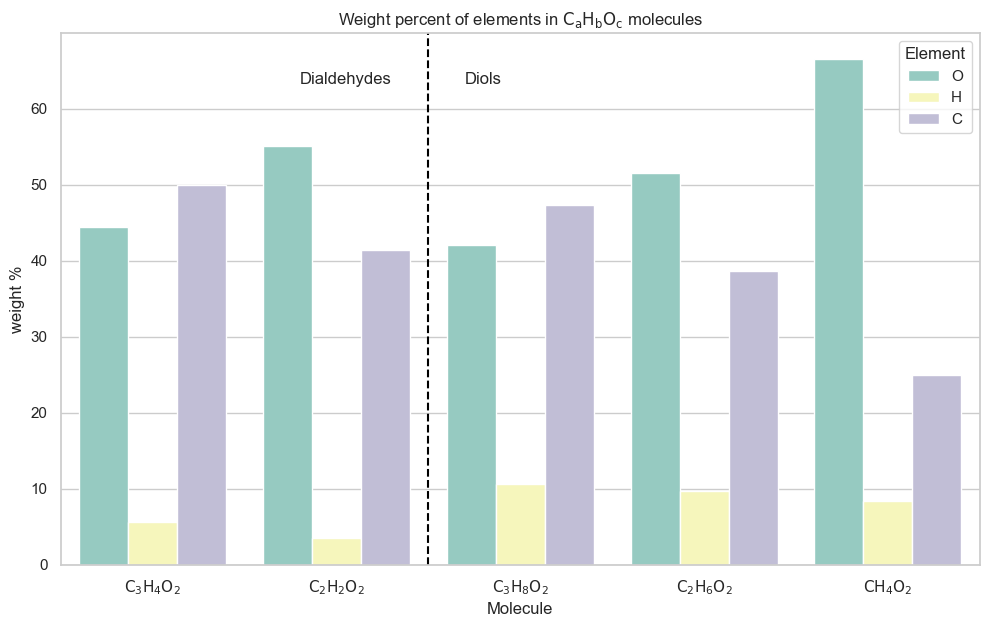

In [19]:
# Create the column plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.legend(title="Element")
plt.tight_layout()

# Use hue (color) to group by elements (O, H, C)
sns.barplot(x="Molecule", y="weight %", hue="Element", data=df_melted, palette="Set3")

# Use LaTeX to include a formula in the plot title
class_of_molecules = "$\mathrm{ C_{ a}H_{ b}O_{ c}}$"
plt.title("Weight percent of elements in " + class_of_molecules + " molecules")

# xticks gets the x values from the Molecule column, which are LaTeX strings of the molecular formulas
plt.xticks()

# -----------------------------------------------------
# Divide and label the two series of molecules
# -----------------------------------------------------

# Get length (number of molecules) of first series
len_first_series = len(smlsMatrix[0])

# Calculate the midpoint between the last item of the first series and the first item of the next series
x_between_series = len_first_series - 0.5

# Add a dashed vertical line between the two series
plt.axvline(x=x_between_series, color="black", linestyle="--")

# Calculate the y-coordinate for the labels 5% below the maximum value
y_max = df_melted["weight %"].max()
label_y_pos = 0.95 * y_max

# Add series labels to the left and right of the dashed vertical line
plt.text(
    x=x_between_series - 0.7,
    y=label_y_pos,
    s=series_names[0],
)
plt.text(
    x=x_between_series + 0.2,
    y=label_y_pos,
    s=series_names[1],
)

# Display the plot
plt.show()

Because we used a nested data structure (supported by MolsMatrixToGridImage) for the two series of molecules, we were able to programmatically extract the x coordinate of the dividing line between the two series `x_between_series`, and place a vertical line there, plus series labels on either side.

This graph displays the weight percentages we expect for an elemental analysis of these compounds. For example, for both series (dialdehydes and diols), we can tell that the weight percent of carbon decreases as carbon chain length decreases.

## Conclusion

This was an example of how to display molecular formulas in molecular grids, tables, and graphs for a straightforward calculation. In the next blog posts, we'll apply some of these techniques to a more involved cheminformatics problem.